# DSA4212 Assignment 1
**CAA 17 March 2023 22:06**

## Imports

In [1]:
import os

# Suppress warnings
import warnings
def warn(*args, **kwargs): pass
warnings.warn = warn
warnings.filterwarnings('ignore')

import numpy as np
from tqdm.auto import tqdm
import pylab as plt
import copy
import time
import cv2 as cv
from random import sample
import random
from collections import defaultdict
import pandas as pd
from functools import singledispatch, partial
from pydot import Dot, Cluster, Node, Edge

import torch
from torch import nn
from itertools import count, chain

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from IPython.core.display import display, Image

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive

    !nvidia-smi -L
    !lscpu |grep 'Model name'
    !free -h --si | awk  '/Mem:/{print $2}'

GPU 0: Tesla T4 (UUID: GPU-8caa9397-9fac-1744-bf08-28392bfdf945)
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
12G


## Load Data

In [3]:
if 'google.colab' in str(get_ipython()):
    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/dataset/DSA4212/assignment_1/

class_names = ["fish", "dog", "device", "chainsaw", "church",
               "horn", "truck", "petrol", "golf", "parachute"]

data_train = np.load('assignment_1_train.npz')
data_test = np.load('assignment_1_test.npz')

# set pixel intensities to [0,1]
X_train = data_train["img"].astype(np.float32) / 255.
X_test = data_test["img"].astype(np.float32) / 255.
Y_train = to_categorical(data_train["label"].astype(int))
Y_test = to_categorical(data_test["label"].astype(int))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/dataset/DSA4212/assignment_1


In [4]:
X_train.shape, Y_train.shape

((9296, 128, 128, 3), (9296, 10))

In [5]:
X_test.shape, Y_test.shape

((3856, 128, 128, 3), (3856, 10))

## Utilities

### Dictionary-related

In [6]:
def union(*dicts):
    return {k: v for d in dicts for (k, v) in d.items()}

def path_iter(nested_dict, pfx=()):
    for name, val in nested_dict.items():
        if isinstance(val, dict): yield from path_iter(val, (*pfx, name))
        else: yield ((*pfx, name), val)  

def map_nested(func, nested_dict):
    return {k: map_nested(func, v) if isinstance(v, dict) else func(v) for k,v in nested_dict.items()}

def group_by_key(items):
    res = defaultdict(list)
    for k, v in items: res[k].append(v) 
    return res

### Timer

In [7]:
class Timer:
    def __init__(self, synch=None):
        self.synch = synch or (lambda: None)
        self.synch()
        self.times = [time.perf_counter()]
        self.total_time = 0.0

    def __call__(self, include_in_total=True):
        self.synch()
        self.times.append(time.perf_counter())
        delta_t = self.times[-1] - self.times[-2]
        if include_in_total:
            self.total_time += delta_t
        return delta_t

def localtime():
    return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())

### Logging Table

In [8]:
default_table_formats = {float: '{:{w}.4f}', str: '{:>{w}s}', 'default': '{:{w}}', 'title': '{:>{w}s}'}

def table_formatter(val, is_title=False, col_width=12, formats=None):
    formats = formats or default_table_formats
    type_ = lambda val: float if isinstance(val, (float, np.float)) else type(val)
    return (formats['title'] if is_title else formats.get(type_(val), formats['default'])).format(val, w=col_width)

class Table:
    def __init__(self, keys=None, report=(lambda data: True), formatter=table_formatter):
        self.keys, self.report, self.formatter = keys, report, formatter
        self.log = []
        
    def append(self, data):
        self.log.append(data)
        data = {' '.join(p): v for p,v in path_iter(data)}
        self.keys = self.keys or data.keys()
        if len(self.log) == 1:
            print(*(self.formatter(k, True) for k in self.keys))
        if self.report(data):
            print(*(self.formatter(data[k]) for k in self.keys))
            
    def df(self):
        return pd.DataFrame([{'_'.join(p): v for p,v in path_iter(row)} for row in self.log])  

### Data Preprocessing

In [9]:
def preprocess2(dataset, transforms):
    dataset = copy.copy(dataset)
    for transform in transforms:
        dataset['data'] = transform(dataset['data'])
    return dataset

@singledispatch
def normalise(x, mean, std):
    return (x - mean) / std

@normalise.register(np.ndarray) 
def _(x, mean, std): 
    x = np.array(x, np.float32)
    x -= mean
    x *= 1.0/std
    return x

def unnormalise(x, mean, std):
    return x*std + mean

@singledispatch
def pad(x, border):
    raise NotImplementedError

@pad.register(np.ndarray)
def _(x, border):
    return np.pad(x, [(0, 0), (border, border), (border, border), (0, 0)], mode='reflect')

@singledispatch
def transpose(x, source, target):
    raise NotImplementedError

@transpose.register(np.ndarray)
def _(x, source, target):
    return x.transpose([source.index(d) for d in target]) 

### Data Augmentation

In [10]:
class Crop:
    def __init__(self, h, w):
        self.h, self.w = h, w

    def __call__(self, x, x0, y0):
        return x[..., y0:y0+self.h, x0:x0+self.w]

    def options(self, shape):
        *_, H, W = shape
        return [{'x0': x0, 'y0': y0} for x0 in range(W+1-self.w) for y0 in range(H+1-self.h)]

    def output_shape(self, shape):
        *_, H, W = shape
        return (*_, self.h, self.w)

@singledispatch
def flip_lr(x):
    raise NotImplementedError

@flip_lr.register(np.ndarray)
def _(x): 
    return x[..., ::-1].copy()

class FlipLR:
    def __call__(self, x, choice):
        return flip_lr(x) if choice else x 

    def options(self, shape):
        return [{'choice': b} for b in [True, False]]

class Cutout:
    def __init__(self, h, w):
        self.h, self.w = h, w

    def __call__(self, x, x0, y0):
        x[..., y0:y0+self.h, x0:x0+self.w] = 0.0
        return x

    def options(self, shape):
        *_, H, W = shape
        return [{'x0': x0, 'y0': y0} for x0 in range(W+1-self.w) for y0 in range(H+1-self.h)]    

class Transform():
    def __init__(self, dataset, transforms):
        self.dataset, self.transforms = dataset, transforms
        self.choices = None

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data, labels = self.dataset[index]
        data = data.copy()
        for choices, f in zip(self.choices, self.transforms):
            data = f(data, **choices[index])
        return data, labels

    def set_random_choices(self):
        self.choices = []
        x_shape = self.dataset[0][0].shape
        N = len(self)
        for t in self.transforms:
            self.choices.append(np.random.choice(t.options(x_shape), N))
            x_shape = t.output_shape(x_shape) if hasattr(t, 'output_shape') else x_shape

### Graph Building

In [11]:
sep = '/'

def split(path):
    i = path.rfind(sep) + 1
    return path[:i].rstrip(sep), path[i:]

def normpath(path):
    parts = []
    for p in path.split(sep):
        if p == '..': parts.pop()
        elif p.startswith(sep): parts = [p]
        else: parts.append(p)
    return sep.join(parts)

def has_inputs(node):
    return type(node) == tuple

def pipeline(net):
    return [(sep.join(path), (node if has_inputs(node) else (node, [-1]))) for (path, node) in path_iter(net)]

def build_graph(net):
    flattened = pipeline(net)
    resolve_input = lambda rel_path, path, idx: normpath(sep.join((path, '..', rel_path))) if isinstance(rel_path, str) else flattened[idx+rel_path][0]
    return {path: (node[0], [resolve_input(rel_path, path, idx) for rel_path in node[1]]) for idx, (path, node) in enumerate(flattened)}

class ColorMap(dict):
    palette = ['#'+x for x in (
        'bebada,ffffb3,fb8072,8dd3c7,80b1d3,fdb462,b3de69,fccde5,bc80bd,ccebc5,ffed6f,1f78b4,33a02c,e31a1c,ff7f00,'
        '4dddf8,e66493,b07b87,4e90e3,dea05e,d0c281,f0e189,e9e8b1,e0eb71,bbd2a4,6ed641,57eb9c,3ca4d4,92d5e7,b15928'
    ).split(',')]

    def __missing__(self, key):
        self[key] = self.palette[len(self) % len(self.palette)]
        return self[key]

    def _repr_html_(self):
        css = (
        '.pill {'
            'margin:2px; border-width:1px; border-radius:9px; border-style:solid;'
            'display:inline-block; width:100px; height:15px; line-height:15px;'
        '}'
        '.pill_text {'
            'width:90%; margin:auto; font-size:9px; text-align:center; overflow:hidden;'
        '}'
        )
        s = '<div class=pill style="background-color:{}"><div class=pill_text>{}</div></div>'
        return '<style>'+css+'</style>'+''.join((s.format(color, text) for text, color in self.items()))

def make_dot_graph(nodes, edges, direction='LR', **kwargs):
    class Subgraphs(dict):
        def __missing__(self, path):
            parent, label = split(path)
            subgraph = Cluster(path, label=label, style='rounded, filled', fillcolor='#77777744')
            self[parent].add_subgraph(subgraph)
            return subgraph
    g = Dot(rankdir=direction, directed=True, **kwargs)
    g.set_node_defaults(
        shape='box', style='rounded, filled', fillcolor='#ffffff')
    subgraphs = Subgraphs({'': g})
    for path, attr in nodes:
        parent, label = split(path)
        subgraphs[parent].add_node(
            Node(name=path, label=label, **attr))
    for src, dst, attr in edges:
        g.add_edge(Edge(src, dst, **attr))
    return g

class DotGraph():
    def __init__(self, graph, size=15, direction='LR'):
        self.nodes = [(k, v) for k, (v,_) in graph.items()]
        self.edges = [(src, dst, {}) for dst, (_, inputs) in graph.items() for src in inputs]
        self.size, self.direction = size, direction

    def dot_graph(self, **kwargs):
        return make_dot_graph(self.nodes, self.edges, size=self.size, direction=self.direction,  **kwargs)

    def _repr_png_(self, **kwargs):
        return self.dot_graph(**kwargs).create_png(prog=['dot', '-Gdpi=600'])

# DFS-like
def walk(dct, key):
    return walk(dct, dct[key]) if key in dct else key

def remove_by_type(net, node_type):  
    graph = build_graph(net)
    remap = {k: i[0] for k,(v,i) in graph.items() if isinstance(v, node_type)}
    return {k: (v, [walk(remap, x) for x in i]) for k, (v,i) in graph.items() if not isinstance(v, node_type)}

colors = ColorMap()
def draw(graph):
    return display(DotGraph({p: ({'fillcolor': colors[type(v)], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in graph.items() if v is not None}))

### Training-related
Related to learning rate scheduler

In [12]:
@singledispatch
def cat(*xs):
    raise NotImplementedError

@singledispatch
def to_numpy(x):
    raise NotImplementedError

class PiecewiseLinear:
    def __init__(self, knots, vals):
        self.knots, self.vals = knots, vals
        plt.figure(figsize=(4,3))
        plt.plot(knots, vals)
        plt.title('Learning rate graph')
        plt.show()

    def __call__(self, t):
        return np.interp([t], self.knots, self.vals)[0]

class Const:
    def __init__(self, val):
        self.val = val

    def __call__(self, x):
        return self.val

### PyTorch-related

#### Basic

In [13]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")

@cat.register(torch.Tensor)
def _(*xs):
    return torch.cat(xs)

@to_numpy.register(torch.Tensor)
def _(x):
    return x.detach().cpu().numpy()  

@pad.register(torch.Tensor)
def _(x, border):
    return nn.ReflectionPad2d(border)(x)

@transpose.register(torch.Tensor)
def _(x, source, target):
    return x.permute([source.index(d) for d in target]) 

def to(*args, **kwargs): 
    return lambda x: x.to(*args, **kwargs)

@flip_lr.register(torch.Tensor)
def _(x):
    return torch.flip(x, [-1])

#### Data Loading

In [14]:
class DataLoader():
    def __init__(self, dataset, batch_size, shuffle, set_random_choices=False, num_workers=0, drop_last=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.set_random_choices = set_random_choices
        self.dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=shuffle, drop_last=drop_last
        )
    
    def __iter__(self):
        if self.set_random_choices:
            self.dataset.set_random_choices() 
        return ({'input': x.to(device).half(), 'target': y.to(device).long()} for (x,y) in self.dataloader)
    
    def __len__(self): 
        return len(self.dataloader)

#### NN Layers

In [15]:
class Network(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.graph = build_graph(net)
        for path, (val, _) in self.graph.items(): 
            setattr(self, path.replace('/', '_'), val)

    def nodes(self):
        return (node for node, _ in self.graph.values())

    def forward(self, inputs):
        outputs = dict(inputs)
        for k, (node, ins) in self.graph.items():
            if k not in outputs: 
                outputs[k] = node(*[outputs[x] for x in ins])
        return outputs

    # Set to half precision
    def half(self):
        for node in self.nodes():
            if isinstance(node, nn.Module) and not isinstance(node, nn.BatchNorm2d):
                node.half()
        return self

class Identity:
    def __call__(self, x): return x

class Add:
    def __call__(self, x, y): return x + y 
    
class AddWeighted:
    def __init__(self, wx, wy): self.wx, self.wy = wx, wy
    def __call__(self, x, y): return self.wx*x + self.wy*y 

class Mul(nn.Module):
    def __init__(self, weight):
        super().__init__()
        self.weight = weight
    def __call__(self, x): 
        return x*self.weight

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), x.size(1))

class Concat(nn.Module):
    def forward(self, *xs): return torch.cat(xs, 1)

#### Loss Metrics

In [16]:
# Losses
class CrossEntropyLoss:
    def __call__(self, log_probs, target):
        return torch.nn.functional.nll_loss(log_probs, target, reduction='none')

class Correct:
    def __call__(self, classifier, target):
        return classifier.max(dim=1)[1] == target

x_ent_loss = Network({
    'loss':  (nn.CrossEntropyLoss(reduction='none'), ['logits', 'target']),
    'acc': (Correct(), ['logits', 'target'])
    # since Correct() looks at the highest value, there's no need to convert to probability
    # and thus softmax is not needed
})

#### Optimizers

In [17]:
def nesterov_update(w, dw, v, lr, weight_decay, momentum):
    dw.add_(weight_decay, w).mul_(-lr)
    v.mul_(momentum).add_(dw)
    w.add_(dw.add_(momentum, v))

def zeros_like(weights):
    return [torch.zeros_like(w) for w in weights]

def optimiser(weights, param_schedule, update, state_init):
    weights = list(weights)
    return {'update': update, 'param_schedule': param_schedule, 'step_number': 0, 'weights': weights,  'opt_state': state_init(weights)}

def opt_step(update, param_schedule, step_number, weights, opt_state):
    step_number += 1
    param_values = {k: f(step_number) for k, f in param_schedule.items()}
    for w, v in zip(weights, opt_state):
        if w.requires_grad: update(w.data, w.grad.data, v, **param_values)
    return {'update': update, 'param_schedule': param_schedule, 'step_number': step_number, 'weights': weights,  'opt_state': opt_state}

SGD = partial(optimiser, update=nesterov_update, state_init=zeros_like)

#### Training

In [18]:
def trainable_params(model):
    return {k:p for k,p in model.named_parameters() if p.requires_grad}

def reduce(batches, state, steps):
    for batch in chain(batches, [None]): 
        for step in steps:
            updates = step(batch, state)
            if updates:
                for k,v in updates.items(): state[k] = v
    return state

# define keys in the state dict as constants
MODEL = 'model'
LOSS = 'loss'
OUTPUT = 'output'
OPTS = 'optimisers'
ACT_LOG = 'activation_log'
WEIGHT_LOG = 'weight_log'

# step definitions
def forward(training_mode):
    def step(batch, state):
        if not batch: return
        model = state[MODEL]
        model.train(training_mode) # sets training mode to training_mode
        return {OUTPUT: state[LOSS](model(batch))}
    return step

def backward(dtype=None):
    def step(batch, state):
        state[MODEL].zero_grad()
        if not batch: return
        loss = state[OUTPUT][LOSS]
        if dtype is not None: loss = loss.to(dtype)
        loss.sum().backward()
    return step

def opt_steps(batch, state):
    if not batch: return
    return {OPTS: [opt_step(**opt) for opt in state[OPTS]]}

def log_activations(node_names=('loss', 'acc')):
    def step(batch, state):
        if '_tmp_logs_' not in state:
            state['_tmp_logs_'] = []
        if batch:
            state['_tmp_logs_'].extend((k, state[OUTPUT][k].detach()) for k in node_names)
        else:
            res = {k: to_numpy(torch.cat(xs)).astype(np.float) for k, xs in group_by_key(state['_tmp_logs_']).items()}
            del state['_tmp_logs_']
            return {ACT_LOG: res}
    return step

def epoch_stats(state):
    return {k: np.mean(v) for k, v in state[ACT_LOG].items()}

default_train_steps = (forward(training_mode=True), log_activations(('loss', 'acc')), backward(), opt_steps)
default_valid_steps = (forward(training_mode=False), log_activations(('loss', 'acc')))

def train_epoch(state, timer, train_batches, valid_batches, train_steps=default_train_steps, valid_steps=default_valid_steps):
    train_summary, train_time = epoch_stats(reduce(train_batches, state, train_steps)), timer()
    valid_summary, valid_time = epoch_stats(reduce(valid_batches, state, valid_steps)), timer(include_in_total=False) # DAWNBench rules
    return {
        'train': union({'time': train_time}, train_summary), 
        'valid': union({'time': valid_time}, valid_summary), 
        'total time': timer.total_time
    }

### Essential for preprocessing
- `shuffle(X, Y, seed)`
- `resize(X, image_size)`
- `augment(X, Y, augment_limit, datagen)`
- `sanity_check(datagen, t=4)`

In [19]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

def shuffle(X, Y, seed):
  set_seed(seed)
  indices_shuffled = np.arange(len(X))
  np.random.shuffle(indices_shuffled)
  return X[indices_shuffled], Y[indices_shuffled]

def resize(X, image_size):
  X_resized = []
  for i in X: X_resized.append(cv.resize(i, (image_size, image_size), interpolation=cv.INTER_AREA))
  return np.array(X_resized)

def augment(X, Y, augment_limit, datagen):
  datagen.fit(X)
  for X2, Y2 in datagen.flow(X, Y, batch_size=512):
    X = np.concatenate([X, X2])
    Y = np.concatenate([Y, Y2])
    if Y.shape[0] > augment_limit: break
  return X, Y

def sanity_check(datagen, t=4):
  datagen.fit(X_train)
  plt.figure(figsize=(10*2,(t+1)*2))
  for i, k in enumerate(sample(range(9296), 10)):
    plt.subplot(t+1,10,i+1)
    plt.axis("off")
    plt.imshow(X_train[k])
    plt.title(class_names[np.where(Y_train[k] == 1)[0][0]])
    aug = datagen.flow(X_train[k:k+1], batch_size=4)
    for m in range(t):
      plt.subplot(t+1,10,i+11+10*m)
      plt.axis("off")
      plt.imshow(next(aug)[0].astype('float32'))
      plt.title(class_names[np.where(Y_train[k] == 1)[0][0]])

## Preprocess loaded data
Divided into two stages
1. Resize, augment, shuffle
2. Split, normalize, transpose

### Data augmentation

In [20]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,      
    zoom_range=0.05,
    channel_shift_range=0.2
)

### Preprocessing stage 1

In [21]:
def preprocess1(X, Y, seed=4212, do_resize=True, do_augment=True, do_shuffle=True):
    if do_resize:
        X = resize(X, 32)
    set_seed(seed)
    if do_augment:
        X, Y = augment(X, Y, 12000, datagen)
    if do_shuffle:
        X, Y = shuffle(X, Y, seed)
    return X, Y

(12368, 32, 32, 3) (12368, 10)
(3856, 32, 32, 3) (3856, 10)


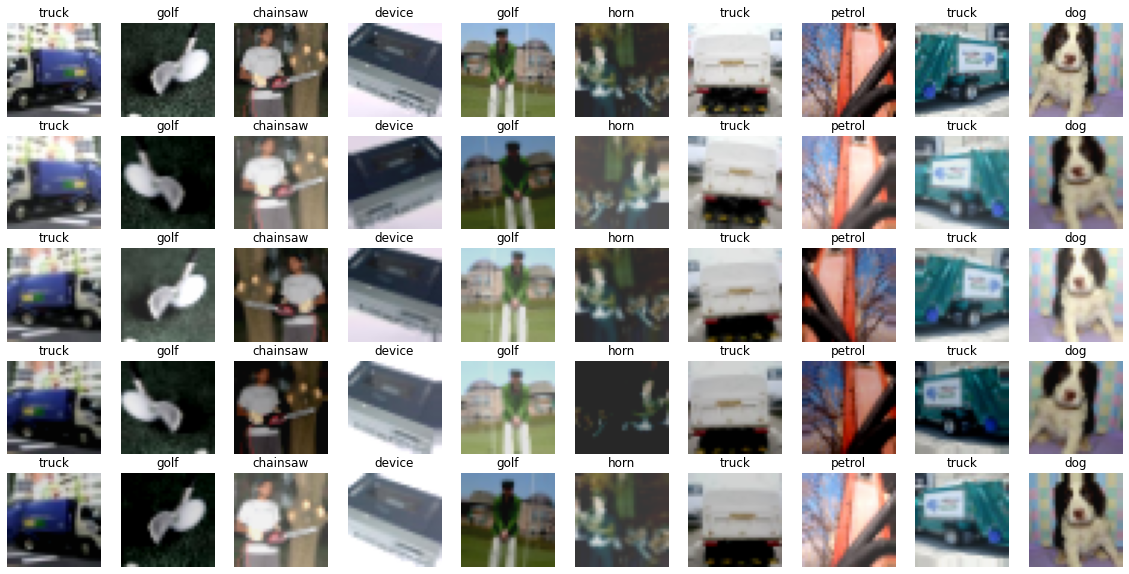

In [22]:
X_train, Y_train = preprocess1(X_train, Y_train)
print(X_train.shape, Y_train.shape)
X_test, Y_test = preprocess1(X_test, Y_test, do_augment=False, do_shuffle=False)
print(X_test.shape, Y_test.shape)

set_seed(4212)
sanity_check(datagen)

### Preprocessing stage 2

In [23]:
train_val_split = 0.8
n_train = int(train_val_split*len(X_train))
X_train, X_val, Y_train, Y_val = X_train[:n_train], X_train[n_train:], Y_train[:n_train], Y_train[n_train:]
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

dataset = {
    'train': {'data': X_train, 'targets': np.where(Y_train == 1)[1]},
    'valid': {'data': X_val, 'targets': np.where(Y_val == 1)[1]},
    'test': {'data': X_test, 'targets': np.where(Y_test == 1)[1]}
}

# partial allows one to call the functions with more keyword arguments later on
# e.g. partial(f, **kw1)(**kw2) = f(**(kw1 | kw2))
transforms = [
    partial(normalise,
            mean=np.array(np.mean(dataset['train']['data'], axis=(0,1,2)), dtype=np.float32),
            std=np.array(np.std(dataset['train']['data'], axis=(0,1,2)), dtype=np.float32)),
    partial(transpose,
            source='NHWC',
            target='NCHW'),
]

(9894, 32, 32, 3) (9894, 10)
(2474, 32, 32, 3) (2474, 10)


In [24]:
# preprocess2 takes in the dataset and a bunch of Transform objects so it works differently than preprocess1
train_set = list(zip(*preprocess2(dataset['train'], [partial(pad, border=4)] + transforms).values()))
valid_set = list(zip(*preprocess2(dataset['valid'], transforms).values()))
test_set = list(zip(*preprocess2(dataset['test'], transforms).values()))

## Model

### Training Pipeline

In [25]:
def train(model, lr_schedule, train_set, valid_set, batch_size, num_workers=0, time_limit=120):
  train_batches = DataLoader(train_set, batch_size, shuffle=True, set_random_choices=True, num_workers=num_workers)
  valid_batches = DataLoader(valid_set, batch_size, shuffle=False, num_workers=num_workers)
  
  # Define learning rate
  lr = lambda step: lr_schedule(step/len(train_batches))/batch_size

  # Use the regular heavy ball
  opts = [SGD(trainable_params(model).values(),
              {'lr': lr, 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)})]
  logs, state = Table(), {MODEL: model, LOSS: x_ent_loss, OPTS: opts}

  # Setup timer
  if torch.cuda.is_available(): tim = Timer(torch.cuda.synchronize)
  else: tim = Timer()

  # Run one epoch
  for epoch in range(lr_schedule.knots[-1]):
    logs.append(union({'epoch': epoch+1, 'lr': lr_schedule(epoch+1)},
                      train_epoch(state, tim, train_batches, valid_batches)))
    # callbacks
    if logs.log[-1]['total time'] > time_limit - logs.log[-1]['train']['time']: break # time limit callback
  print(f'Training stopped after {tim.total_time} seconds')

  return model, logs

def evaluate(model, logs, test_set):
  # Evaluate test set
  eval_tim = Timer()
  accuracies = [] # to verify that the test set does not affect the model, they should all be the same
  for _ in range(5):
    stats = epoch_stats(reduce(
        DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0),
        {MODEL: model, LOSS: x_ent_loss},
        default_valid_steps))
    accuracies.append(stats['acc'])
    assert len(accuracies) < 2 or accuracies[-1] == accuracies[-2], 'Accuracy changed, model affected!'
  print(f"Final validation accuracy: {stats['acc']*100}%")

  # Accuracy plot
  plt.plot([s['epoch'] for s in logs.log], [s['train']['acc'] for s in logs.log], label='train')
  plt.plot([s['epoch'] for s in logs.log], [s['valid']['acc'] for s in logs.log], label='valid')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()
  print(f'Evaluation and plotting done after {eval_tim()} seconds')

  return model, logs

### Architecture

In [26]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight_freeze=False, bias_freeze=False):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.requires_grad = not weight_freeze
        self.bias.requires_grad = not bias_freeze

# Define frozen batch norm
batch_norm = partial(BatchNorm, weight_freeze=True)

# Initialize Conv2d with random weights
old_nn_conv2d = nn.Conv2d
def conv2d(*args, **kwargs):
    c = old_nn_conv2d(*args, **kwargs)
    # Normally it uses Kaiming uniform but experience tells it's better to use Glorot uniform
    nn.init.xavier_uniform(c.weight)
    return c

# Basic building blocks
def conv_bn_relu(c_in, c_out, pool=True, **kw):
    # conv -> norm -> pool -> act
    if pool:
      return {
          'conv': conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False),
          'norm': batch_norm(c_out, **kw),
          'pool': nn.MaxPool2d(2),
          'act': nn.ReLU(True)
      }
    else:
      return {
          'conv': conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False),
          'norm': batch_norm(c_out, **kw),
          'act': nn.ReLU(True)
      }

def conv_bn_celu(alpha):
  def layer(c_in, c_out, pool=True, **kw):
    # conv -> norm -> pool -> act
    if pool:
      return {
          'conv': conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False),
          'norm': batch_norm(c_out, **kw),
          'pool': nn.MaxPool2d(2),
          'act': nn.CELU(alpha=alpha, inplace=True)
      }
    else:
      return {
          'conv': conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False),
          'norm': batch_norm(c_out, **kw),
          'act': nn.CELU(alpha=alpha, inplace=True)
      }
  return layer

# Compound all building blocks into a single network
def DAWN_net(channels, base_block, extra_layers, residual_layers, **kw):
    # x + relu(res2(res1(x)))
    residual = lambda c, **kw: {
        'in': Identity(),
        'res1': base_block(c, c, pool=False, **kw),
        'res2': base_block(c, c, pool=False, **kw),
        'add': (Add(), ['in', 'res2/act'])
    }

    '''
    input -> (conv, norm, act)                              # prep
          -> (conv, norm, pool(2), act, extra?residual?)    # layer1
          -> (conv, norm, pool(2), act, extra?residual?)    # layer2
          -> (conv, norm, pool(2), act, extra?residual?)    # layer3
          -> pool(4) -> flatten -> dense(10) -> output
    '''

    n = {
        'input': (None, []),
        'prep': base_block(3, channels['prep'], pool=False, **kw),
        'layer1': base_block(channels['prep'], channels['layer1'], **kw),
        'layer2': base_block(channels['layer1'], channels['layer2'], **kw),
        'layer3': base_block(channels['layer2'], channels['layer3'], **kw),
        'pool': nn.MaxPool2d(4),
        'flatten': Flatten(),
        'linear': nn.Linear(channels['layer3'], 10, bias=False),
        'logits': Mul(0.125), # tuned hyperparameter
    }

    # apply ResNet connections or make it deeper
    for layer in residual_layers:
        n[layer]['residual'] = residual(channels[layer], **kw)
    for layer in extra_layers:
        n[layer]['extra'] = base_block(channels[layer], channels[layer], pool=False, **kw)
    
    draw(build_graph(n))
    return Network(n).to(device).half()

In [27]:
relu = conv_bn_relu
celu = partial(conv_bn_celu)

## Training

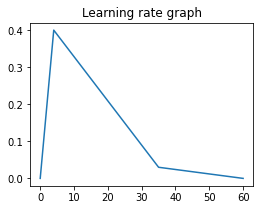

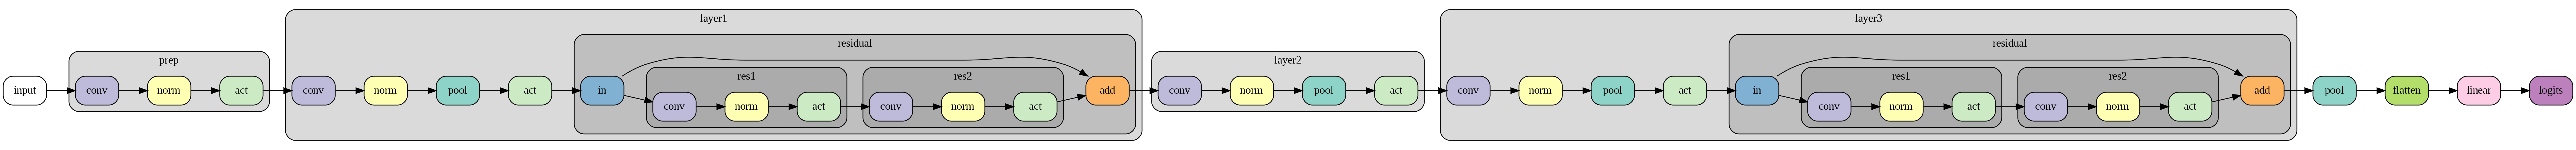

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       2.3528       1.8926       0.3406       0.1698       2.1406       0.3573       2.3528
           2       0.2000       2.3220       1.4351       0.5182       0.1718       1.9421       0.4939       4.6747
           3       0.3000       2.3381       1.2890       0.5874       0.1748       1.4549       0.5825       7.0129
           4       0.4000       2.3451       1.2567       0.6022       0.1740       1.5110       0.5869       9.3580
           5       0.3881       2.3445       1.1228       0.6413       0.1746       1.4798       0.5364      11.7025
           6       0.3761       2.3508       0.9833       0.6774       0.1763       1.0622       0.6665      14.0534
           7       0.3642       2.3543       0.9139       0.7017       0.1791       0.9557       0.6896      16.4077
           8       0.3523       2.3770       0.8532       0.7183

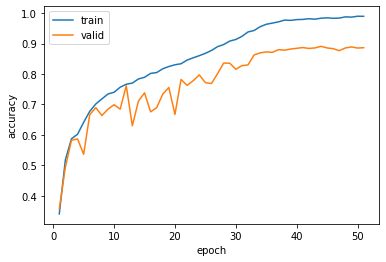

Evaluation and plotting done after 52.52819121199991 seconds


In [34]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=relu,
    extra_layers=[],
    residual_layers=['layer1', 'layer3'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])
model, summary = train(model, lr_schedule, train_set_x, valid_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

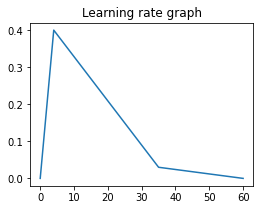

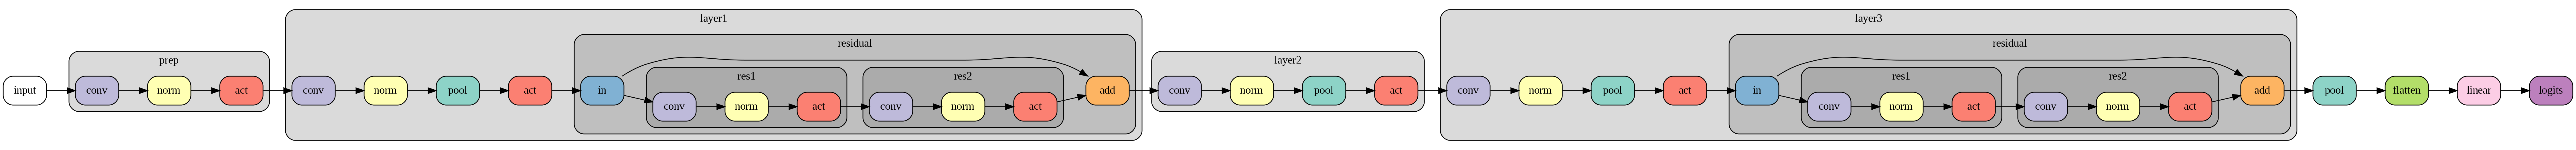

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       2.4123       1.8900       0.3405       0.1771       2.5375       0.2886       2.4123
           2       0.2000       2.3513       1.4143       0.5249       0.1771       1.7080       0.5040       4.7636
           3       0.3000       2.3638       1.2755       0.5815       0.1808       1.6548       0.5501       7.1274
           4       0.4000       2.3869       1.2245       0.6075       0.1808       1.5682       0.5772       9.5143
           5       0.3881       2.3882       1.1219       0.6390       0.1810       1.3939       0.5578      11.9024
           6       0.3761       2.3996       0.9756       0.6846       0.1827       1.0401       0.6665      14.3021
           7       0.3642       2.4157       0.9040       0.7035       0.1827       1.1316       0.6390      16.7178
           8       0.3523       2.4127       0.8539       0.7226

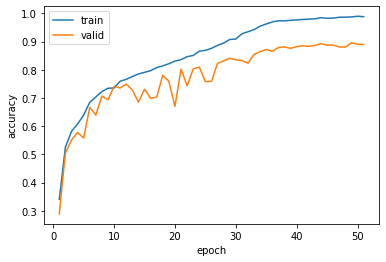

Evaluation and plotting done after 52.46381939999992 seconds


In [35]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.05),
    extra_layers=[],
    residual_layers=['layer1', 'layer3'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])
model, summary = train(model, lr_schedule, train_set_x, valid_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

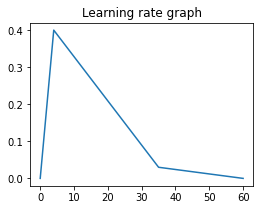

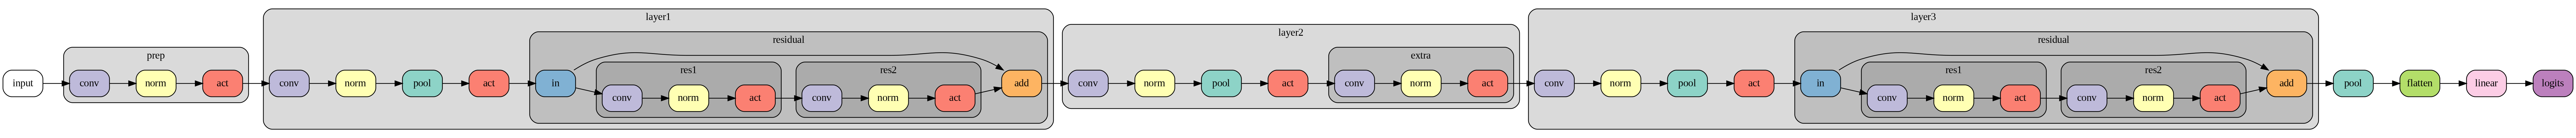

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       3.0534       1.9174       0.3242       0.2457       1.9222       0.3994       3.0534
           2       0.2000       2.9967       1.4364       0.5211       0.2422       1.7215       0.4960       6.0501
           3       0.3000       2.6820       1.2752       0.5786       0.2140       1.4640       0.5388       8.7321
           4       0.4000       2.5412       1.2098       0.6058       0.1889       1.4366       0.5631      11.2734
           5       0.3881       2.5402       1.1114       0.6417       0.1900       1.3002       0.6043      13.8136
           6       0.3761       2.5523       0.9610       0.6849       0.1968       1.0442       0.6673      16.3659
           7       0.3642       2.5736       0.9229       0.6973       0.1918       1.2089       0.6245      18.9394
           8       0.3523       2.5659       0.8577       0.7194

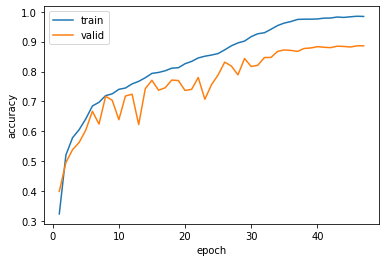

Evaluation and plotting done after 60.81649028399988 seconds


In [36]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.05),
    extra_layers=['layer2'],
    residual_layers=['layer1', 'layer3'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])
model, summary = train(model, lr_schedule, train_set_x, valid_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

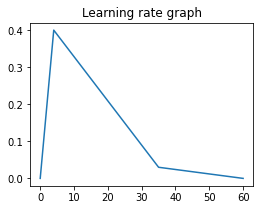

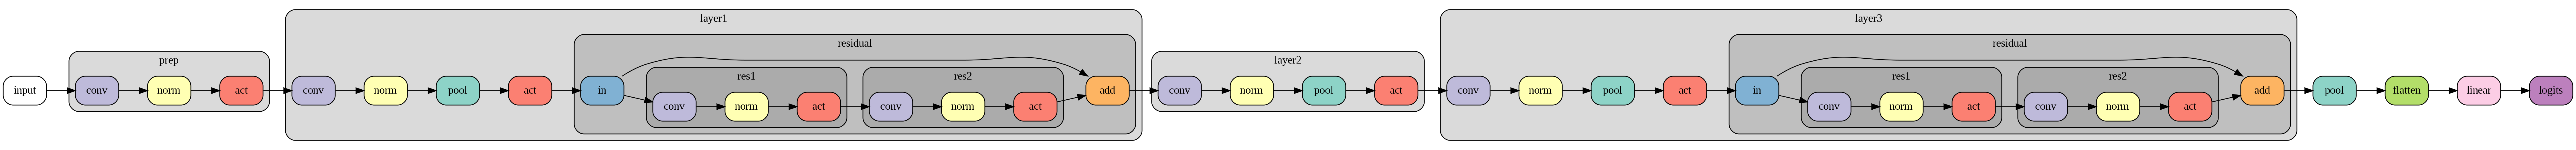

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       2.4237       1.8554       0.3595       0.1778       2.2764       0.3319       2.4237
           2       0.2000       2.3654       1.3356       0.5573       0.1782       1.7389       0.5202       4.7891
           3       0.3000       2.3785       1.2130       0.6014       0.1824       1.3006       0.6027       7.1676
           4       0.4000       2.3900       1.1484       0.6349       0.1827       1.1196       0.6580       9.5576
           5       0.3881       2.7799       1.0165       0.6720       0.2488       1.6211       0.5449      12.3376
           6       0.3761       2.4550       0.9028       0.7067       0.1866       1.4130       0.5869      14.7925
           7       0.3642       2.4396       0.8225       0.7323       0.1826       0.9067       0.7154      17.2322
           8       0.3523       2.4249       0.7774       0.7442

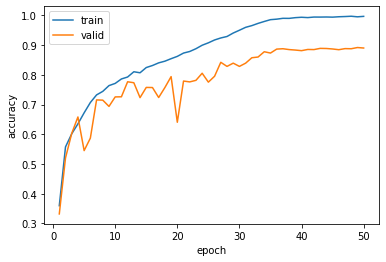

Evaluation and plotting done after 55.05745050900077 seconds


In [37]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.05),
    extra_layers=[],
    residual_layers=['layer1', 'layer3'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8, 8)])
model, summary = train(model, lr_schedule, train_set_x, valid_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

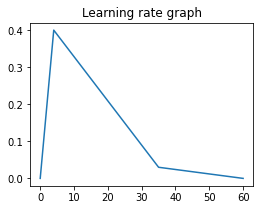

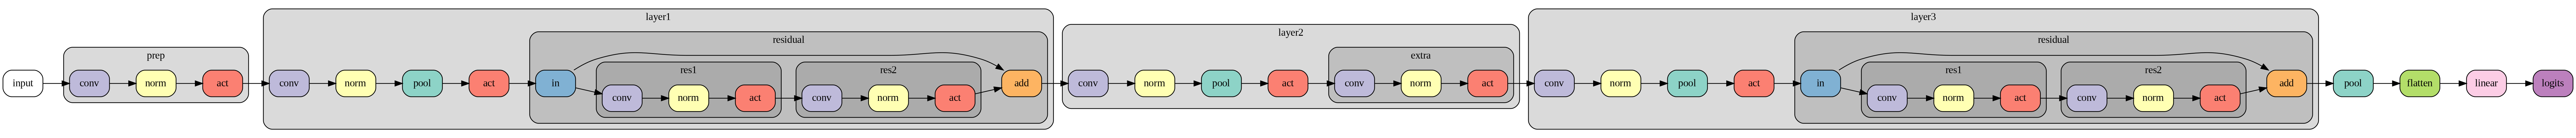

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       2.5728       1.8728       0.3451       0.1863       1.7907       0.4034       2.5728
           2       0.2000       2.5363       1.3545       0.5512       0.1922       1.8828       0.4879       5.1091
           3       0.3000       2.5453       1.1958       0.6072       0.1924       1.2722       0.5905       7.6544
           4       0.4000       2.5735       1.1327       0.6305       0.1936       1.1531       0.6467      10.2279
           5       0.3881       2.5826       1.0137       0.6732       0.1943       1.2531       0.6273      12.8105
           6       0.3761       2.5834       0.8902       0.7130       0.1947       1.0597       0.6641      15.3939
           7       0.3642       2.5946       0.8339       0.7257       0.1940       1.3196       0.5845      17.9885
           8       0.3523       2.5980       0.7937       0.7432

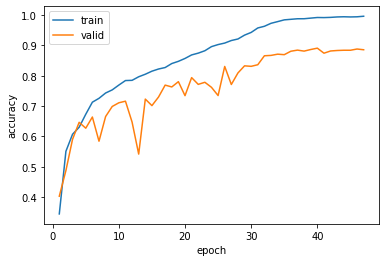

Evaluation and plotting done after 57.58674974399946 seconds


In [38]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.05),
    extra_layers=['layer2'],
    residual_layers=['layer1', 'layer3'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8, 8)])
model, summary = train(model, lr_schedule, train_set_x, valid_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

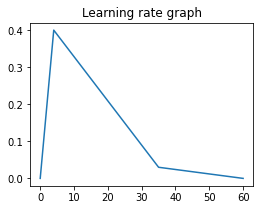

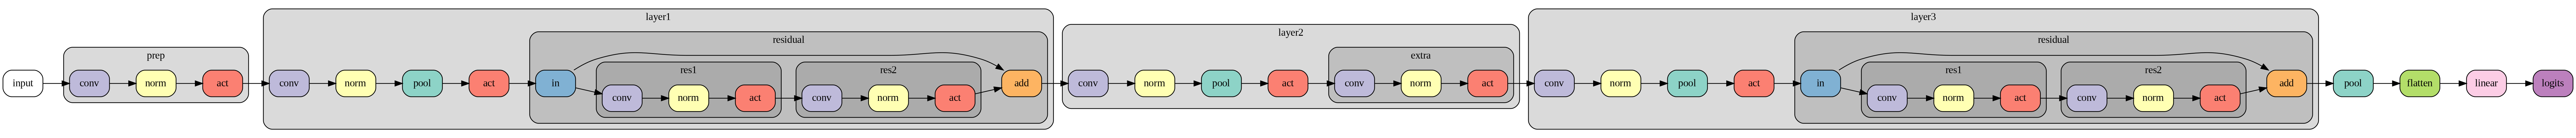

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       2.6704       1.9242       0.3213       0.1892       1.6755       0.4616       2.6704
           2       0.2000       2.5594       1.4406       0.5196       0.1925       1.6253       0.5154       5.2298
           3       0.3000       2.5619       1.2757       0.5779       0.1926       1.3851       0.5667       7.7917
           4       0.4000       2.5714       1.2172       0.6073       0.1948       1.6763       0.5000      10.3631
           5       0.3881       2.5841       1.1072       0.6393       0.1949       1.4422       0.5574      12.9472
           6       0.3761       2.5956       0.9546       0.6862       0.1965       1.1397       0.6354      15.5428
           7       0.3642       2.6044       0.9252       0.6927       0.1950       1.1384       0.6512      18.1472
           8       0.3523       2.5968       0.8687       0.7149

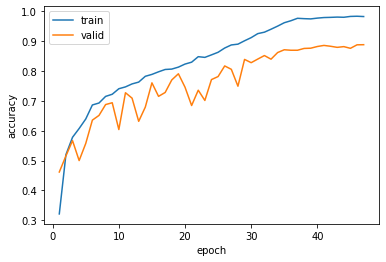

Evaluation and plotting done after 56.55284663800012 seconds


In [40]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.03),
    extra_layers=['layer2'],
    residual_layers=['layer1', 'layer3'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])
model, summary = train(model, lr_schedule, train_set_x, valid_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

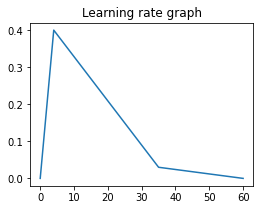

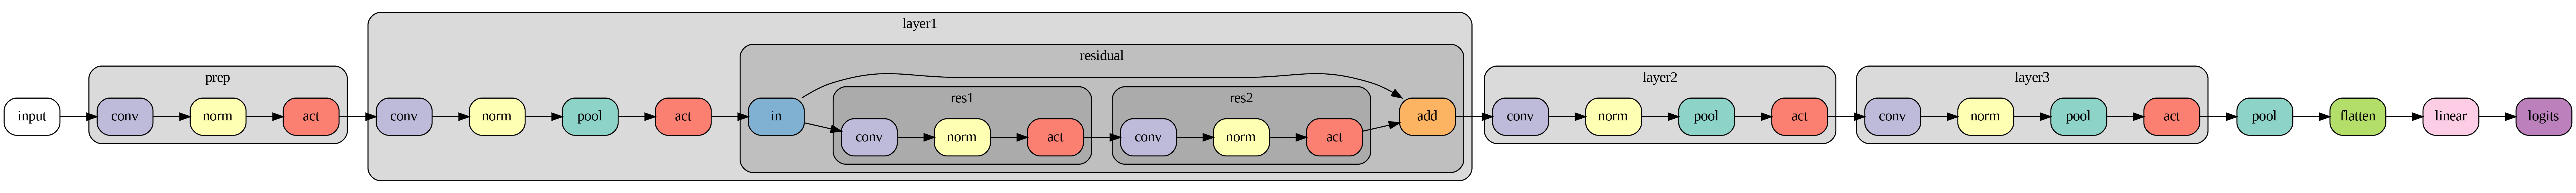

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       2.5610       1.9880       0.2995       0.1451       1.8437       0.3901       2.5610
           2       0.2000       1.9792       1.4442       0.5222       0.1466       1.3934       0.5489       4.5402
           3       0.3000       1.9810       1.2209       0.5971       0.1474       1.3026       0.5736       6.5212
           4       0.4000       1.9903       1.1394       0.6289       0.1486       1.6435       0.5049       8.5116
           5       0.3881       1.9940       1.0594       0.6505       0.1471       1.1096       0.6479      10.5055
           6       0.3761       2.0104       0.9594       0.6900       0.1532       0.9246       0.7025      12.5159
           7       0.3642       2.0265       0.9163       0.6950       0.1495       1.1000       0.6572      14.5424
           8       0.3523       2.0182       0.8671       0.7171

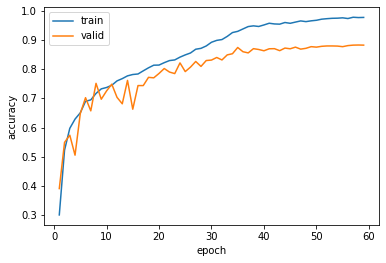

Evaluation and plotting done after 42.09995231500034 seconds


In [42]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.03),
    extra_layers=[],
    residual_layers=['layer1'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])
model, summary = train(model, lr_schedule, train_set_x, valid_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

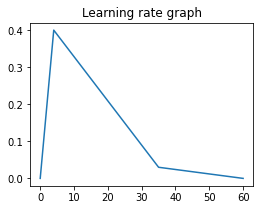

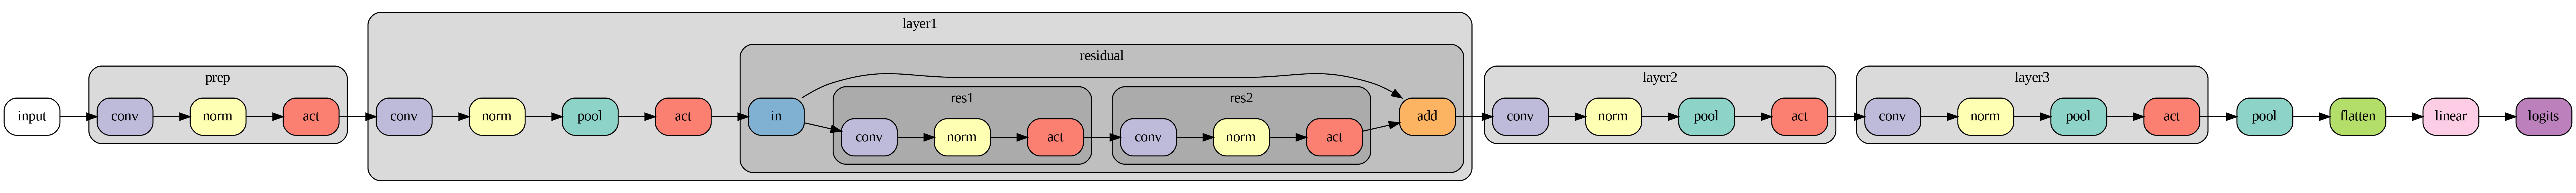

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       2.0015       1.9852       0.3024       0.1461       1.8280       0.3682       2.0015
           2       0.2000       1.9540       1.4431       0.5205       0.1458       1.3695       0.5703       3.9555
           3       0.3000       1.9408       1.2204       0.5962       0.1454       1.3087       0.5829       5.8962
           4       0.4000       1.9513       1.1397       0.6270       0.1481       2.2709       0.3670       7.8475
           5       0.3881       1.9502       1.0687       0.6508       0.1453       1.2257       0.6108       9.7977
           6       0.3761       1.9556       0.9646       0.6857       0.1463       1.0138       0.6637      11.7533
           7       0.3642       1.9639       0.9165       0.6978       0.1510       1.0537       0.6694      13.7173
           8       0.3523       1.9769       0.8676       0.7143

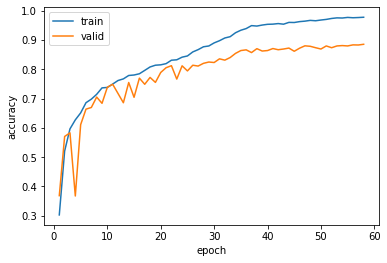

Evaluation and plotting done after 42.25029061299938 seconds


In [50]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.03),
    extra_layers=[],
    residual_layers=['layer1'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])
model, summary = train(model, lr_schedule, train_set_x, valid_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

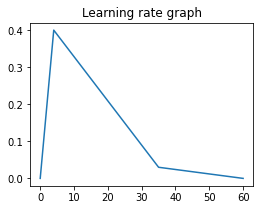

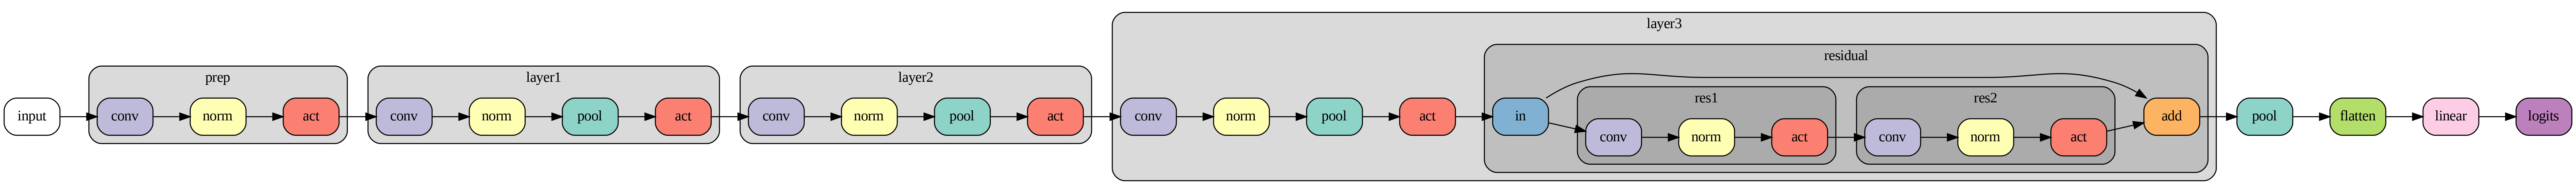

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       2.0886       1.8992       0.3366       0.1461       1.7423       0.4503       2.0886
           2       0.2000       2.0348       1.3870       0.5361       0.2507       1.5529       0.5194       4.1234
           3       0.3000       2.2330       1.2530       0.5859       0.1438       1.3844       0.5954       6.3564
           4       0.4000       1.9501       1.2128       0.6120       0.1429       1.1792       0.6172       8.3065
           5       0.3881       1.9544       1.0932       0.6416       0.1425       1.3390       0.6087      10.2609
           6       0.3761       1.9592       0.9883       0.6778       0.1472       1.0744       0.6597      12.2201
           7       0.3642       1.9718       0.8914       0.7045       0.1420       1.1022       0.6621      14.1918
           8       0.3523       1.9796       0.8768       0.7155

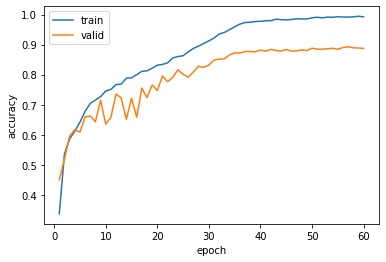

Evaluation and plotting done after 41.62005288 seconds


In [43]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.03),
    extra_layers=[],
    residual_layers=['layer3'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])
model, summary = train(model, lr_schedule, train_set_x, valid_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

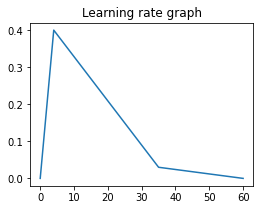

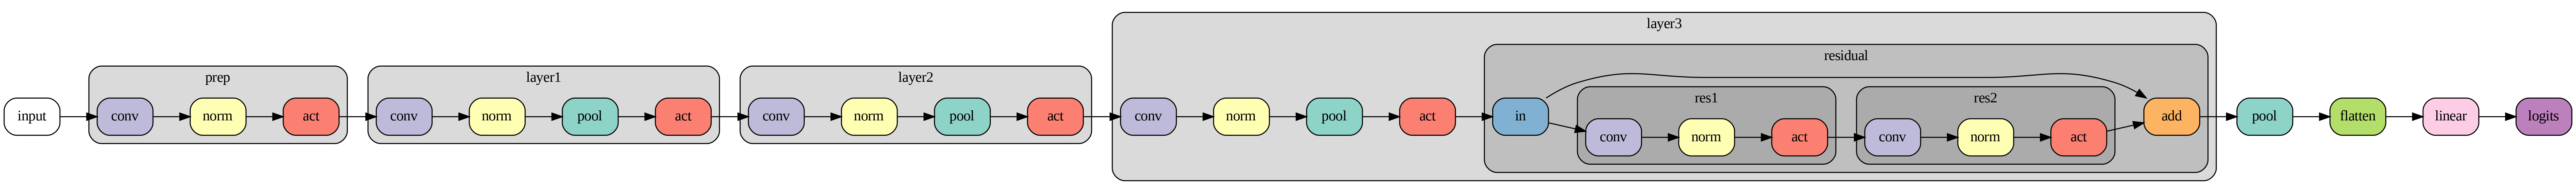

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       2.5237       1.9000       0.3364       0.2032       1.5968       0.4648       2.5237
           2       0.2000       1.9525       1.3867       0.5365       0.1390       1.7031       0.4992       4.4762
           3       0.3000       1.9533       1.2464       0.5868       0.1432       1.4595       0.5845       6.4295
           4       0.4000       1.9528       1.2085       0.6132       0.1478       1.4826       0.5412       8.3823
           5       0.3881       1.9607       1.0829       0.6484       0.1440       1.3845       0.5974      10.3430
           6       0.3761       1.9681       0.9774       0.6850       0.1452       1.1354       0.6411      12.3111
           7       0.3642       1.9786       0.8914       0.7054       0.1437       1.0257       0.6738      14.2897
           8       0.3523       1.9909       0.8677       0.7153

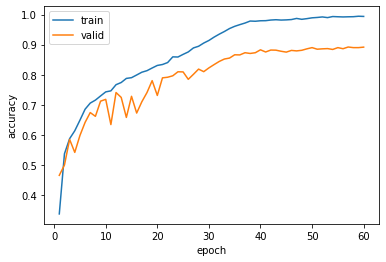

Evaluation and plotting done after 41.851078650001 seconds


In [47]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.03),
    extra_layers=[],
    residual_layers=['layer3'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])
model, summary = train(model, lr_schedule, train_set_x, valid_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

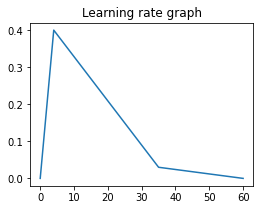

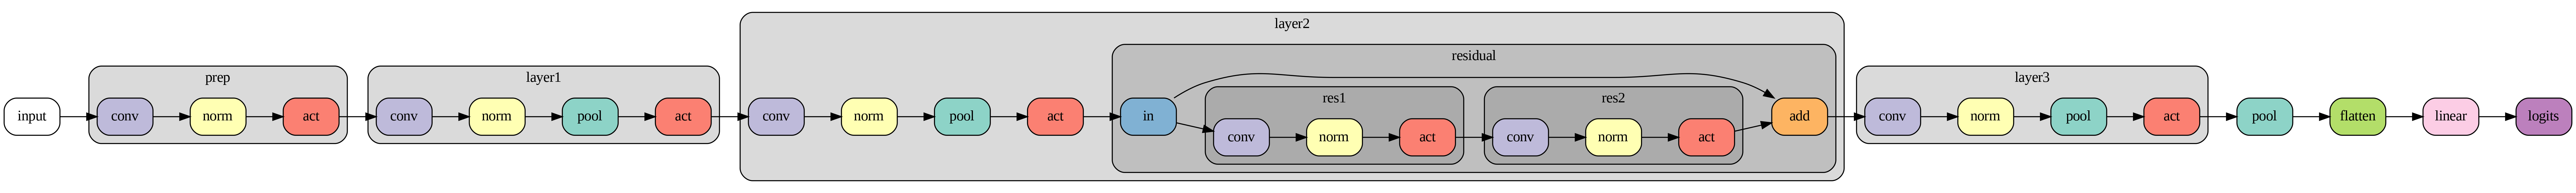

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       1.9983       1.9860       0.3095       0.1427       1.7388       0.4119       1.9983
           2       0.2000       1.9720       1.4248       0.5253       0.1403       1.4590       0.5416       3.9703
           3       0.3000       1.9752       1.2046       0.5983       0.1418       1.6245       0.5218       5.9455
           4       0.4000       1.9879       1.1203       0.6335       0.1408       1.9260       0.4911       7.9334
           5       0.3881       1.9939       1.0418       0.6556       0.1411       1.0566       0.6629       9.9273
           6       0.3761       1.9978       0.9398       0.6882       0.1442       0.9923       0.6851      11.9250
           7       0.3642       2.0049       0.9119       0.6970       0.1440       0.9621       0.6867      13.9299
           8       0.3523       2.0216       0.8482       0.7210

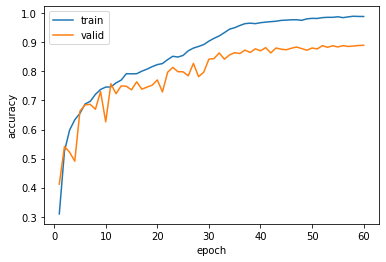

Evaluation and plotting done after 41.11439832499855 seconds


In [48]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.03),
    extra_layers=[],
    residual_layers=['layer2'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])
model, summary = train(model, lr_schedule, train_set_x, valid_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

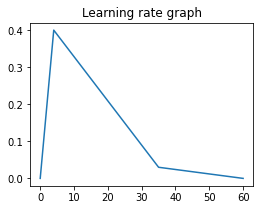

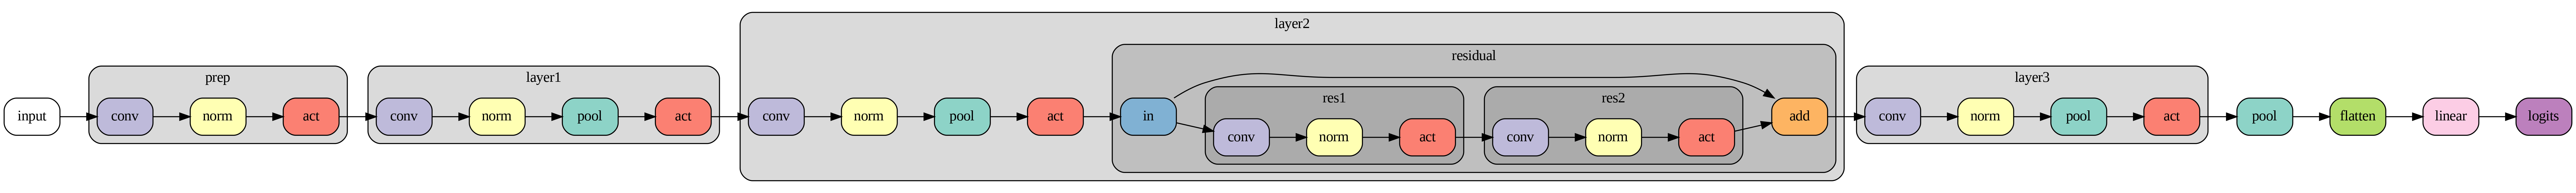

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       2.0366       1.9854       0.3104       0.1408       1.7433       0.4281       2.0366
           2       0.2000       1.9649       1.4252       0.5274       0.1467       1.4246       0.5485       4.0016
           3       0.3000       1.9797       1.1992       0.6016       0.1441       1.6159       0.5194       5.9813
           4       0.4000       1.9773       1.1371       0.6299       0.1431       1.4817       0.5457       7.9585
           5       0.3881       1.9773       1.0450       0.6564       0.1424       1.1861       0.6128       9.9359
           6       0.3761       1.9882       0.9403       0.6856       0.1412       1.0407       0.6706      11.9240
           7       0.3642       1.9966       0.9115       0.6961       0.1424       0.9947       0.6778      13.9206
           8       0.3523       2.0032       0.8464       0.7219

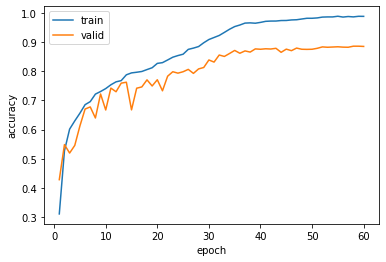

Evaluation and plotting done after 41.0801988889998 seconds


In [49]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.03),
    extra_layers=[],
    residual_layers=['layer2'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])
model, summary = train(model, lr_schedule, train_set_x, valid_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

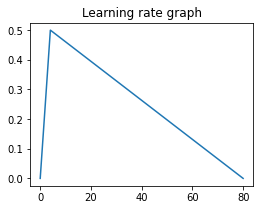

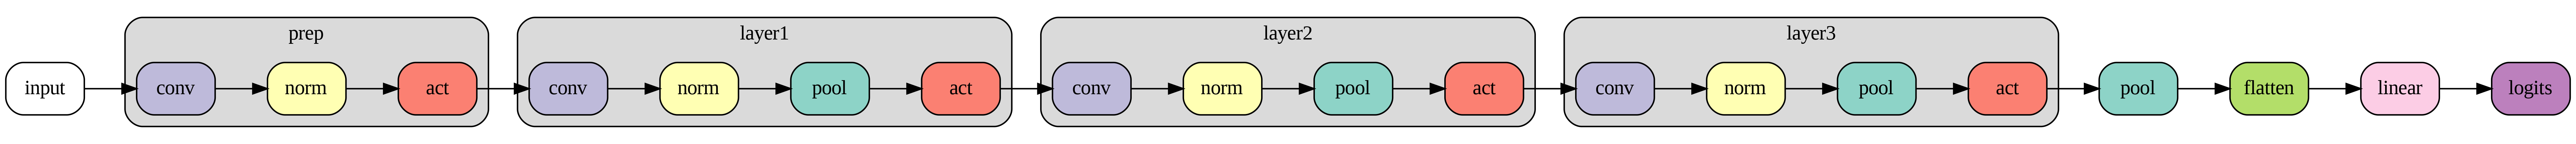

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1250       1.6321       1.9717       0.3152       0.1114       1.9692       0.3100       1.6321
           2       0.2500       1.5870       1.4224       0.5237       0.1152       1.6079       0.4669       3.2191
           3       0.3750       1.5948       1.2354       0.5872       0.1155       1.1321       0.6346       4.8140
           4       0.5000       1.5979       1.1511       0.6250       0.1133       1.2887       0.5938       6.4119
           5       0.4934       1.6074       1.0958       0.6446       0.1173       1.7126       0.5424       8.0193
           6       0.4868       1.6168       1.0082       0.6688       0.1149       1.2486       0.6055       9.6361
           7       0.4803       1.6155       0.9588       0.6891       0.1168       1.0625       0.6673      11.2516
           8       0.4737       1.6195       0.9162       0.7021

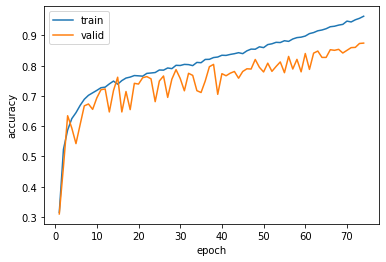

Evaluation and plotting done after 36.88201898400075 seconds


In [46]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 80], [0, 0.5, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.03),
    extra_layers=[],
    residual_layers=[],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])
model, summary = train(model, lr_schedule, train_set_x, valid_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

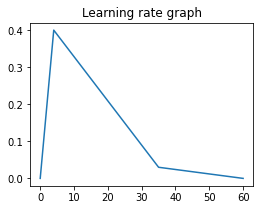

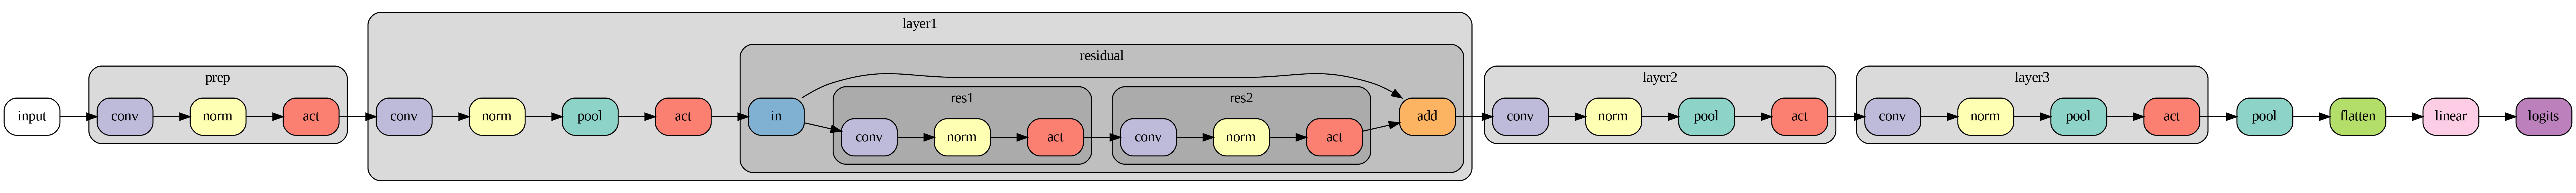

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       2.0479       1.9685       0.3118       0.1497       1.7517       0.4103       2.0479
           2       0.2000       1.9978       1.3780       0.5402       0.1522       1.5532       0.5129       4.0457
           3       0.3000       1.9999       1.1576       0.6218       0.1499       1.2113       0.5901       6.0456
           4       0.4000       2.0047       1.0810       0.6417       0.1496       1.2847       0.6079       8.0503
           5       0.3881       2.0085       0.9688       0.6839       0.1509       1.0675       0.6528      10.0588
           6       0.3761       2.0118       0.8925       0.7089       0.1503       0.9384       0.7029      12.0706
           7       0.3642       2.0294       0.8327       0.7275       0.1522       0.9448       0.7013      14.1000
           8       0.3523       2.1267       0.7916       0.7391

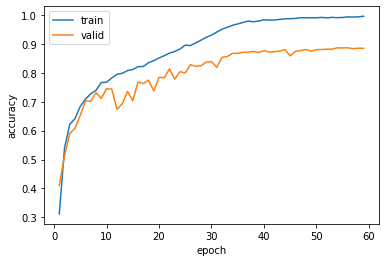

Evaluation and plotting done after 42.6751196109999 seconds


In [51]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.03),
    extra_layers=[],
    residual_layers=['layer1'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8, 8)])
model, summary = train(model, lr_schedule, train_set_x, valid_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

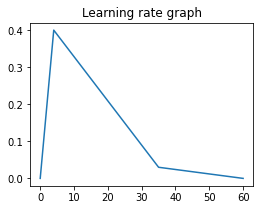

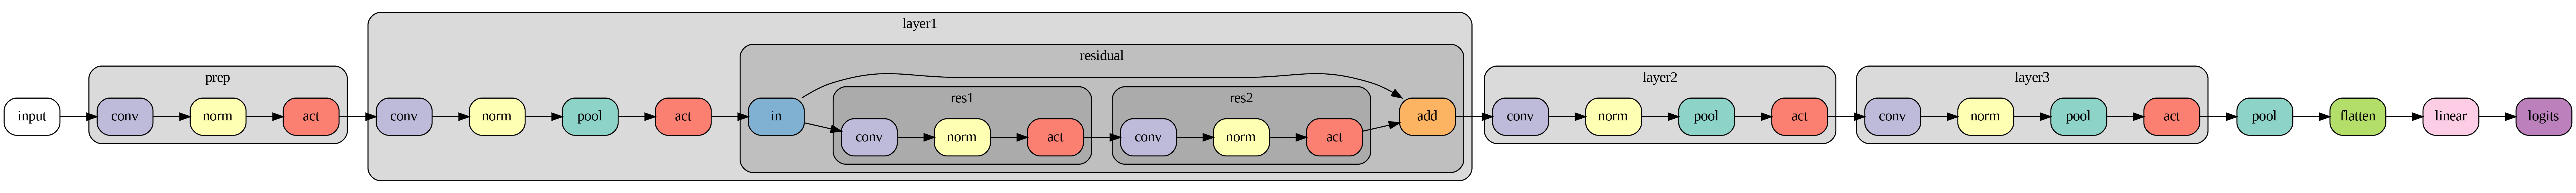

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       2.0265       1.9854       0.3040       0.2866       2.1023       0.3335       2.0265
           2       0.2000       1.9830       1.4472       0.5198       0.2333       1.3023       0.5654       4.0095
           3       0.3000       1.9962       1.2248       0.5961       0.2288       1.6503       0.4948       6.0057
           4       0.4000       1.9991       1.1368       0.6261       0.2329       1.8252       0.4850       8.0048
           5       0.3881       1.9991       1.0682       0.6538       0.2342       1.0233       0.6668      10.0039
           6       0.3761       2.0142       0.9605       0.6864       0.2345       0.9308       0.6966      12.0180
           7       0.3642       2.0185       0.9182       0.6946       0.2344       0.9735       0.6839      14.0366
           8       0.3523       2.0348       0.8761       0.7100

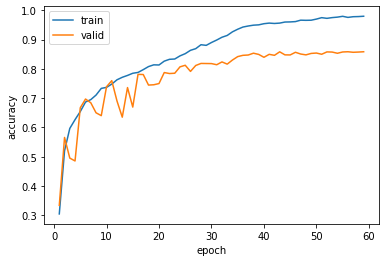

Evaluation and plotting done after 42.5435394749984 seconds


In [52]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.03),
    extra_layers=[],
    residual_layers=['layer1'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(12, 12)])
model, summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

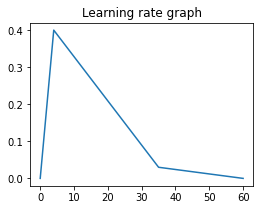

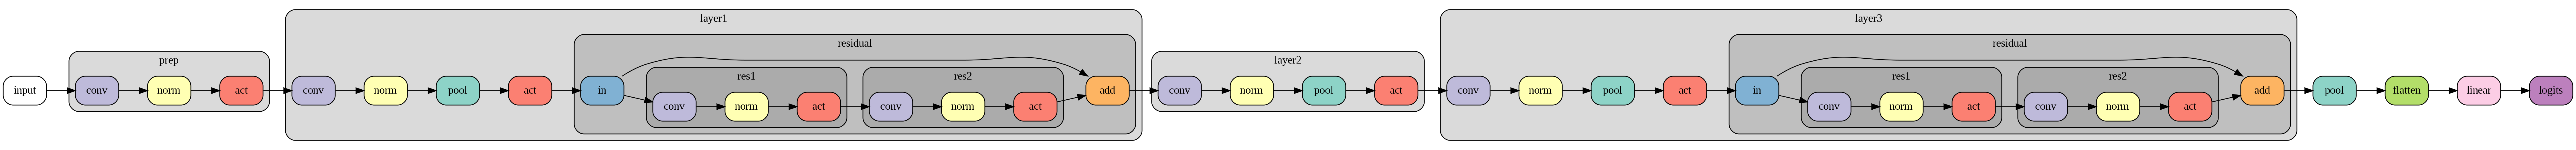

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       2.4937       1.8280       0.3669       0.3096       2.7734       0.3288       2.4937
           2       0.2000       2.3367       1.3117       0.5640       0.2743       1.6032       0.5368       4.8303
           3       0.3000       2.3462       1.1578       0.6212       0.2752       1.3645       0.5928       7.1766
           4       0.4000       2.3566       1.1091       0.6443       0.2850       1.3187       0.6144       9.5332
           5       0.3881       2.3711       0.9360       0.6978       0.2807       1.7621       0.5091      11.9043
           6       0.3761       2.3727       0.8281       0.7298       0.2822       1.2339       0.6229      14.2770
           7       0.3642       2.3863       0.7377       0.7619       0.2835       0.9498       0.6942      16.6633
           8       0.3523       2.4067       0.6725       0.7762

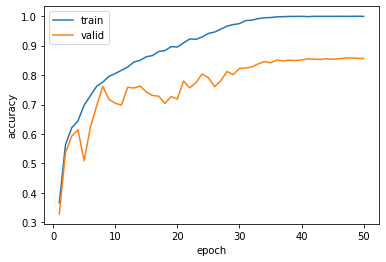

Evaluation and plotting done after 52.69942424000146 seconds


In [58]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.03),
    extra_layers=[],
    residual_layers=['layer1', 'layer3'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
model, summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

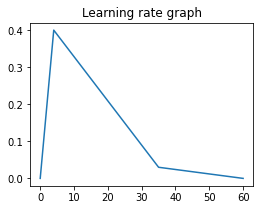

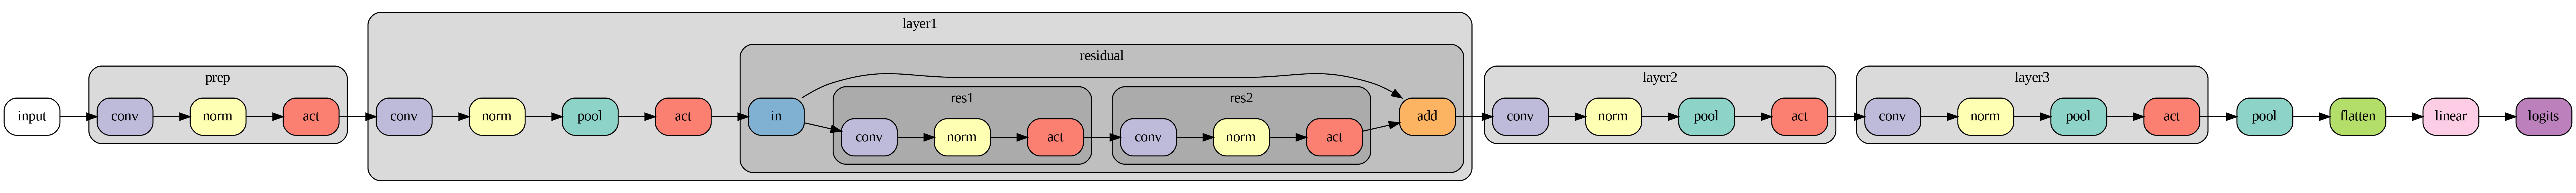

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       2.0226       1.9482       0.3212       0.1513       1.6900       0.4264       2.0226
           2       0.2000       1.9940       1.3415       0.5524       0.1490       1.1660       0.6205       4.0166
           3       0.3000       1.9956       1.1003       0.6400       0.1502       1.3293       0.5671       6.0122
           4       0.4000       2.0119       1.0168       0.6634       0.1519       1.5233       0.5287       8.0241
           5       0.3881       2.0256       0.9309       0.6919       0.1522       1.0503       0.6556      10.0497
           6       0.3761       2.0255       0.8373       0.7272       0.1502       0.8829       0.7179      12.0752
           7       0.3642       2.0305       0.7635       0.7513       0.1508       0.8250       0.7397      14.1057
           8       0.3523       2.0385       0.7303       0.7619

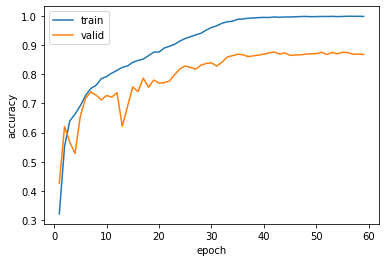

Evaluation and plotting done after 43.082450182000684 seconds


In [59]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.03),
    extra_layers=[],
    residual_layers=['layer1'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(4, 4)])
model, summary = train(model, lr_schedule, train_set_x, valid_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

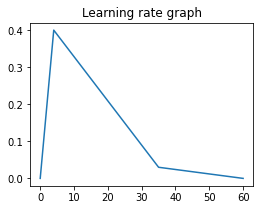

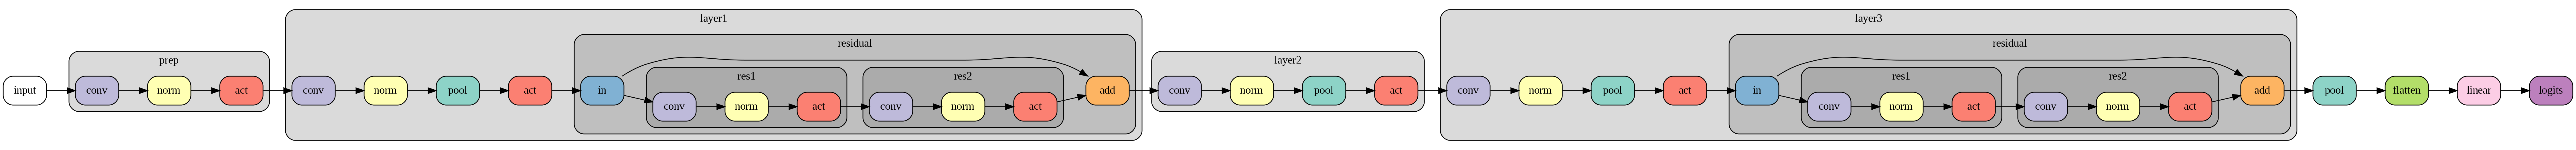

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       2.4097       1.8367       0.3642       0.1777       3.0277       0.3007       2.4097
           2       0.2000       2.3466       1.3168       0.5546       0.1775       1.4547       0.5602       4.7563
           3       0.3000       2.3521       1.1523       0.6242       0.1784       1.5639       0.5497       7.1084
           4       0.4000       2.3646       1.1176       0.6430       0.1776       1.1940       0.6427       9.4730
           5       0.3881       2.3800       0.9627       0.6912       0.1808       1.2821       0.6006      11.8530
           6       0.3761       2.3834       0.8330       0.7283       0.1831       1.6353       0.5323      14.2364
           7       0.3642       2.4031       0.7563       0.7543       0.1835       0.9609       0.6985      16.6395
           8       0.3523       2.4093       0.7167       0.7653

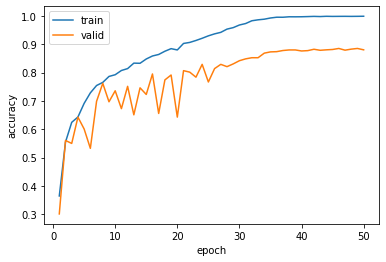

Evaluation and plotting done after 52.134196048000376 seconds


In [61]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.03),
    extra_layers=[],
    residual_layers=['layer1', 'layer3'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(4, 4)])
model, summary = train(model, lr_schedule, train_set_x, valid_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

## Predicting

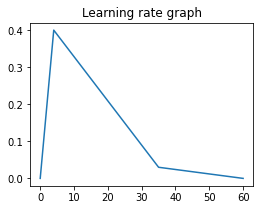

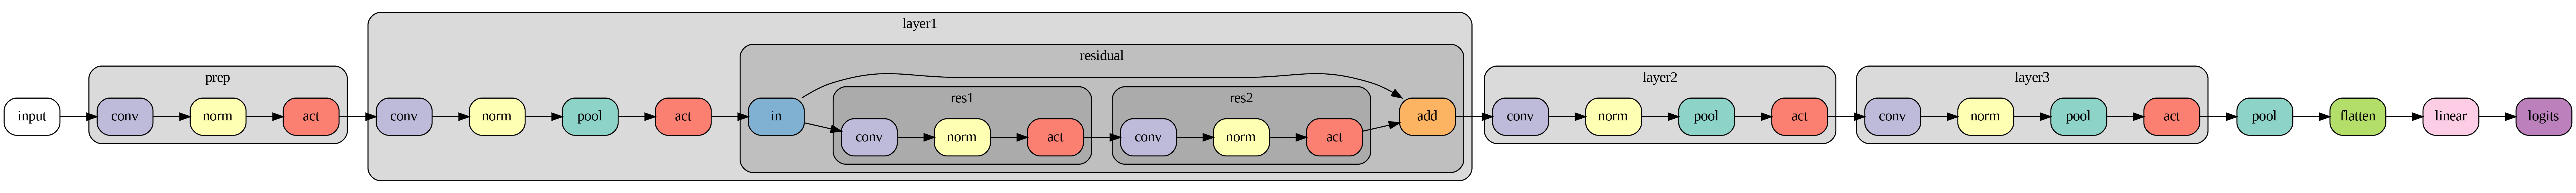

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       2.0368       1.9869       0.3039       0.1520       1.7716       0.3783       2.0368
           2       0.2000       1.9942       1.4342       0.5211       0.1550       1.7570       0.4612       4.0310
           3       0.3000       2.0014       1.2237       0.5955       0.1509       1.4749       0.5287       6.0324
           4       0.4000       1.9998       1.1320       0.6266       0.1476       1.2709       0.6067       8.0321
           5       0.3881       2.0087       1.0423       0.6619       0.1497       1.0349       0.6669      10.0408
           6       0.3761       2.0126       0.9520       0.6894       0.1512       1.0030       0.6730      12.0535
           7       0.3642       2.0198       0.8841       0.7098       0.1511       1.0698       0.6556      14.0733
           8       0.3523       2.0272       0.8452       0.7229

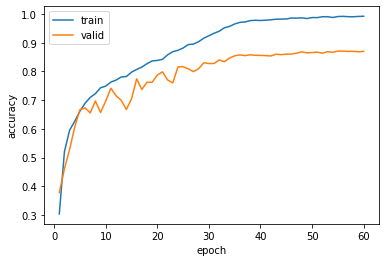

Evaluation and plotting done after 42.471742304000145 seconds


In [71]:
set_seed(4212)
lr_schedule = PiecewiseLinear([0, 4, 35, 60], [0, 0.4, 0.03, 0])
model = DAWN_net(
    channels={'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512},
    base_block=celu(0.03),
    extra_layers=[],
    residual_layers=['layer1'],
)
batch_size = 128
train_set_x = Transform(train_set, [Crop(32, 32), Cutout(12, 12)])
model, summary = train(model, lr_schedule, train_set_x, valid_set, batch_size=batch_size, num_workers=0)
model, summary = evaluate(model, summary, test_set)

In [70]:
model

Network(
  (prep_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (prep_norm): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prep_act): CELU(alpha=0.03, inplace=True)
  (layer1_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1_norm): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1_act): CELU(alpha=0.03, inplace=True)
  (layer1_residual_res1_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1_residual_res1_norm): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1_residual_res1_act): CELU(alpha=0.03, inplace=True)
  (layer1_residual_res2_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1_residual_res2_norm): BatchN

In [30]:
def predict(model, X, Y):
  '''
  X: (32, 32, 3) array
  Y: (10,) array or a single integer
  '''
  assert X.shape == (32, 32, 3)
  assert (type(Y) == int and 0 <= Y <= 9) or (type(Y) != int and Y.shape == (10,))
  plt.imshow(X)
  Y_c = np.argmax(Y) if type(Y) != int else Y
  plt.title(class_names[Y_c])
  plt.show()
  for batch in DataLoader(
      list(zip(*preprocess2({
        'data': np.expand_dims(X, axis=0),
        'targets': np.expand_dims(Y_c, axis=0)
      }, transforms).values())),
      batch_size=1, shuffle=False, num_workers=0):
    probs = nn.Softmax(1)(model(batch)['logits'])[0]
    for i, p in enumerate(probs):
      print(f'{(class_names[i]+":").ljust(12)}{round(p.item()*100, 4)}%')

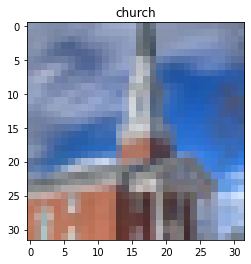

fish:       0.0%
dog:        0.0%
device:     0.0%
chainsaw:   0.0%
church:     100.0%
horn:       0.0%
truck:      0.0%
petrol:     0.0004%
golf:       0.0%
parachute:  0.0002%


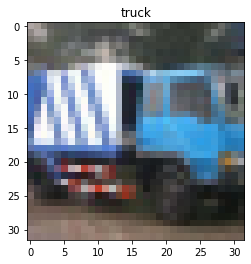

fish:       0.0001%
dog:        0.0001%
device:     0.0022%
chainsaw:   0.0003%
church:     0.001%
horn:       0.0001%
truck:      100.0%
petrol:     0.0012%
golf:       0.0%
parachute:  0.0013%


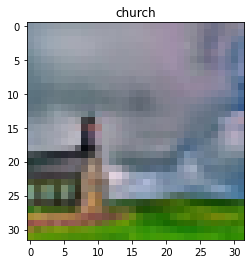

fish:       0.0004%
dog:        0.0016%
device:     0.0005%
chainsaw:   0.0038%
church:     97.6074%
horn:       0.0%
truck:      0.0043%
petrol:     1.3603%
golf:       0.9872%
parachute:  0.0348%


In [31]:
from random import randint
for _ in range(3):
  idx = randint(0, len(X_test))
  predict(model, X_test[idx], Y_test[idx])